# Variational Auto-Encoder notebook using tensorflow

(Edit) I fixed this notebook so that it can be run top to bottom to reproduce everything. Also to get the ipython notebook format, change "html" to "ipynb" at the end of the URL above to access the notebook file.

## Introduction:

In this blog series we are going to build towards a rather complicated, deep learning model that can be applied to an interesting bioinformatics application. I don't want to explain the end goal right now, since I want to keep that confidential until it is published. However the end goal is complicated enough, and I am unfamiliar with both the deep learning models, and the tensorflow framwork, that we aren't going to try to implement the end goal in one shot, rather we are going to implement a series of smaller simpler tensorflow models, to build up some pieces that can then be assembled later. 

In this series we will investigate deep generative models such as Variational Auto-Encoders (VAE) and Generative Adversarial Networks (GAN). We will also develop recurrent neural networks, including LSTM and especially seq2seq models.

To start off, in this notebook, we look below at a VAE on the MNIST dataset, just to get familiar with VAE's, and generative models overall (which will be a piece that we need later), and to get familliar with tensorflow.

A lot of this notebook is taken and modified from https://jmetzen.github.io/2015-11-27/vae.html

In [1]:
import sys
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

# get the script bellow from 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/input_data.py
import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Description of the MNIST dataset:

Let me describe the data which was downloaded/loaded in the cell above:
The data is the familliar mnist dataset, a classic dataset for supervised machine learning, consisting of images of handrawn digits and their labels.

In [2]:
# We have training data Images 28x28=782 gray scale pixels (a list of 782 length numpy vectors):
print(mnist.train.images[0].shape) # 784
print(len(mnist.train.images)) # 55000
print(sys.getsizeof(mnist.train.images)) # 172 million bytes (fits in memory, yay!)

# the labels are stored as one-hot encoding (10 dimensional numpy vectors)
print(mnist.train.labels[0].shape) # 10
print(len(mnist.train.labels)) # 55000

# We also have 5000 validation image-label pairs
print(len(mnist.validation.labels)) # 5000

# and 10000 testing image-label pairs
print(len(mnist.test.labels)) # 10000

(784,)
55000
172480112
(10,)
55000
5000
10000


## Building the model

Let me briefly explain in words how a VAE works. First, like all generative models, VAEs are inherently unsupervised, here we aren't going to use the "labels" at all and we aren't going to use the validation or testing sets. How a VAE works, is that it takes an input, in this case a MNIST image, and maps that onto an internal encoding/embedding, which is then used to reconstruct the original input image.

In the specific case of deep VAE, we have a neural network (the enncoder/recognition network) that transforms the input, x, into a set of parameters that determine a probability distribution. This probability distribution is then sampled from to get a vector z. That vector is fed into a second network (the decoder/generator network) which attempts to output the original image, x, with maximum accuracy. The whole thing can be trained iteratively with simple gradient decent via back propogation.

Note that `n_z` samples of the latent distribution will be drawn for each input image

In [3]:
# hyper params:
n_hidden_recog_1=500 # 1st layer encoder neurons
n_hidden_recog_2=500 # 2nd layer encoder neurons

n_hidden_gener_1=500 # 1st layer decoder neurons
n_hidden_gener_2=500 # 2nd layer decoder neurons
n_input=784 # MNIST data input (img shape: 28*28)
n_z=20

transfer_fct=tf.nn.softplus
learning_rate=0.001
batch_size=100

# CREATE NETWORK

# 1) input placeholder
x = tf.placeholder(tf.float32, [None, n_input])

# 2) weights and biases variables
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [4]:
wr_h1 = tf.Variable(xavier_init(n_input, n_hidden_recog_1))
wr_h2 = tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2))
wr_out_mean = tf.Variable(xavier_init(n_hidden_recog_2, n_z))
wr_out_log_sigma = tf.Variable(xavier_init(n_hidden_recog_2, n_z))

br_b1 = tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32))
br_b2 = tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32))
br_out_mean = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
br_out_log_sigma = tf.Variable(tf.zeros([n_z], dtype=tf.float32))

wg_h1 = tf.Variable(xavier_init(n_z, n_hidden_gener_1))
wg_h2 = tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2))
wg_out_mean = tf.Variable(xavier_init(n_hidden_gener_2, n_input))
# wg_out_log_sigma = tf.Variable(xavier_init(n_hidden_gener_2, n_input))

bg_b1 = tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32))
bg_b2 = tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32))
bg_out_mean = tf.Variable(tf.zeros([n_input], dtype=tf.float32))

# 3) recognition network
    
# use recognition network to predict mean and (log) variance of (latent) Gaussian distribution z (n_z dimensional)
r_layer_1 = transfer_fct(tf.add(tf.matmul(x, wr_h1), br_b1)) 
r_layer_2 = transfer_fct(tf.add(tf.matmul(r_layer_1, wr_h2), br_b2)) 
z_mean = tf.add(tf.matmul(r_layer_2, wr_out_mean), br_out_mean)
z_sigma = tf.add(tf.matmul(r_layer_2, wr_out_log_sigma), br_out_log_sigma)

# 4) do sampling on recognition network to get latent variables
# draw one n_z dimensional sample (for each input in batch), from normal distribution
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)

# scale that set of samples by predicted mu and epsilon to get samples of z, the latent distribution
# z = mu + sigma*epsilon
z = tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_sigma)), eps))

# 5) use generator network to predict mean of Bernoulli distribution of reconstructed input
g_layer_1 = transfer_fct(tf.add(tf.matmul(z, wg_h1), bg_b1)) 
g_layer_2 = transfer_fct(tf.add(tf.matmul(g_layer_1, wg_h2), bg_b2)) 
x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(g_layer_2, wg_out_mean), bg_out_mean))

## Loss and Optimizer

The loss function is in two parts. One that measures how well the reconstruction "fits" the original image, and one that measures the "complexity" of the latent distribution (acting as a regularizer).

In [5]:
# DEFINE LOSS AND OPTIMIZER

# The loss is composed of two terms:
# 1.) The reconstruction loss (the negative log probability
#     of the input under the reconstructed Bernoulli distribution 
#     induced by the decoder in the data space).
#     This can be interpreted as the number of "nats" required
#     for reconstructing the input when the activation in latent
#     is given.
# Adding 1e-10 to avoid evaluatio of log(0.0)
reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_reconstr_mean) + (1-x) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)

# 2.) The latent loss, which is defined as the Kullback Leibler divergence 
##    between the distribution in latent space induced by the encoder on 
#     the data and some prior. This acts as a kind of regularizer.
#     This can be interpreted as the number of "nats" required
#     for transmitting the the latent space distribution given
#     the prior.
latent_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma), 1)

# Since reconstr_loss and latent_loss are in terms of "nats" they
# should be on simmilar scales. So we can add them together.
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# 3) set up optimizer (use ADAM optimizer)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

## Graphs, sessions and state-initialization

The above cells determine the tensorflow "graph" i.e. the graph consisting of nodes of ops connected by directed tensor-edges. But the graph above cannot be run yet. It hasn't been initialized into a "working graph" with statefull variables. The tensorflow tutorials refer to the graph as something like a "blueprint".

The session contains the state for a specific graph, including the current values of all of the tensors in the graph. Once the session is created, the variables are initialized. From now on, the variables have state, and can be read/viewed, or updated iteratively according to the data and the optimization op.

In [6]:
# INITALIZE VARIABLES AND TF SESSION
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init)

## Interactive tensorflow

Because this is an ipython notebook and we are doing exploratory machine learning, we should have an ability to interact with the tensorflow model interactively. Note the line above `sess = tf.InteractiveSession()` which allows us to do things like `some_tensor.eval(feed_dict={x: batch_xs})`. Some tensors can simplly be evaluated without passing in an input, but only if they are something that does not depend on an input, remember tensor flow is a directed graph of op-nodes and tensor-edges that denote dependancies. Variables like weights and biases do not depend on any input, but something like the reconstructed input depends on the input.

In [7]:
# INTERACTIVE TESTING

# get a batch of inputs
batch_xs, _ = mnist.train.next_batch(batch_size)

# get the reconstructed mean for those inputs 
# (on a completely untrained model)

# below is the "interactive version" to "read" a tensor (given an input in the feed_dict)
print(x_reconstr_mean.eval(feed_dict={x: batch_xs}).shape)
print(x_reconstr_mean.eval(feed_dict={x: batch_xs}))
print("----------------------------------------------------")

# below is the same but using explicit reference to the session state
print(tf.get_default_session().run(x_reconstr_mean, feed_dict={x: batch_xs}).shape)
print(tf.get_default_session().run(x_reconstr_mean, feed_dict={x: batch_xs}))

# and this is also the same thing:
print(sess.run(x_reconstr_mean, feed_dict={x: batch_xs}).shape)
print(sess.run(x_reconstr_mean, feed_dict={x: batch_xs}))

(100, 784)
[[ 0.55051911  0.40011126  0.3229681  ...,  0.26033628  0.58813155
   0.20437056]
 [ 0.57137889  0.5061518   0.34375036 ...,  0.22695893  0.51370138
   0.20259285]
 [ 0.58117056  0.50989521  0.35513604 ...,  0.23161986  0.52315634
   0.21537764]
 ..., 
 [ 0.57774663  0.46956134  0.33718172 ...,  0.23101389  0.55720443
   0.20294861]
 [ 0.51590729  0.41846776  0.3130773  ...,  0.2515009   0.55255795
   0.21712792]
 [ 0.6265803   0.51528865  0.33480164 ...,  0.24471143  0.5109762
   0.21917991]]
----------------------------------------------------
(100, 784)
[[ 0.59873706  0.52164662  0.30310315 ...,  0.2332325   0.53049982
   0.21333706]
 [ 0.58268529  0.52849817  0.33210298 ...,  0.25906435  0.5255186
   0.20378244]
 [ 0.5623455   0.47688237  0.31704688 ...,  0.25530595  0.55603069
   0.21486403]
 ..., 
 [ 0.54478884  0.47610471  0.32800055 ...,  0.24576949  0.54282737
   0.21436095]
 [ 0.58914107  0.50816834  0.33034298 ...,  0.24959403  0.52000642
   0.21440969]
 [ 0.46251

## Interpretting the above interactive results

Note that the three printed reconstructions are not the same!! This isn't due to some bug. This is because the model is inherently stocastic. Given the same input, the reconstructions will be different. Especially here, with an untrained model.

Also note for the above tensors we printed, they are 100 by 784 dim tensors. The first dim, 100 is the batch size. The second dim, 784, is the flattened pixels in the reconstructed image. 

This interactive testing can be usefull for tensorflow noobs, who want to make sure that their tensors and ops are compatible as they build thier evaluation graph one tensor/op at a time.

Remember, when using interactive tensorflow you have access to the current state of the model at any time. Just use `eval`. Even without interactive mode, it is still easy, you just have to make sure to keep the `session` which holds the tensorflow graph's state.

## Adding a Saver to record checkpoints

The session contains state, namely the current values of all of the variables (parameters) in the model. We can save this state to a file periodically which can be used to restart training after an interuption, or to reload the session/model for any reason (including perhaps deploying a trained model to be evaluated on another machine)

In [8]:
# make a saver object
saver = tf.train.Saver()

# save the current state of the session to file "model.ckpt"
save_path = saver.save(sess, "model.ckpt")

# a binding to a session can be restored from a file with the following
restored_session = tf.Session()
saver.restore(restored_session, "model.ckpt")

# prove the two sessions are equal:
# here we evaluate a weight variable that does not depend on input hence no feed_dict is nessisary
print(sess.run(wr_h1))
print("-------------------------------------------------------------------")
print(restored_session.run(wr_h1))

[[ -3.04449610e-02  -4.03854474e-02  -6.99873269e-03 ...,  -5.53035215e-02
   -2.33481303e-02   2.55972967e-02]
 [ -4.29244712e-02  -5.99403046e-02   9.38922167e-05 ...,  -6.28070980e-02
    2.16583088e-02  -2.74170302e-02]
 [  5.78668341e-02  -3.77356112e-02   2.27410495e-02 ...,   6.79159984e-02
   -4.94433455e-02   5.71967885e-02]
 ..., 
 [  6.58601150e-02   2.81353742e-02   1.51272267e-02 ...,   4.06232327e-02
   -4.02223505e-02   5.10606244e-02]
 [  3.01660523e-02  -6.09270185e-02   2.00164169e-02 ...,   6.56487271e-02
   -1.20700561e-02   2.39140242e-02]
 [ -4.65316661e-02   7.90952891e-03  -1.24603286e-02 ...,  -5.18925041e-02
    5.54503128e-02  -4.16721851e-02]]
-------------------------------------------------------------------
[[ -3.04449610e-02  -4.03854474e-02  -6.99873269e-03 ...,  -5.53035215e-02
   -2.33481303e-02   2.55972967e-02]
 [ -4.29244712e-02  -5.99403046e-02   9.38922167e-05 ...,  -6.28070980e-02
    2.16583088e-02  -2.74170302e-02]
 [  5.78668341e-02  -3.77356

## Use scopes and names to organize your tensorflow graph

group tensors with `with tf.name_scope('hidden') as scope:`
and name tensors with the `name` property like `a = tf.constant(5, name='alpha')` prior to graph visualization.

## Use summaries to record how your model changes over training-time
Lets reorganize our computational graph with scopes and names, and add some summaries:

There are three summaries which we will add to the "cost" tensor.
We will record its mean, standard deviation and histogram over a batch.


Below is the whole graph from above again. Lots of copying and pasting.

In [9]:
# remake the whole graph with scopes, names, summaries

wr_h1 = tf.Variable(xavier_init(n_input, n_hidden_recog_1))
wr_h2 = tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2))
wr_out_mean = tf.Variable(xavier_init(n_hidden_recog_2, n_z))
wr_out_log_sigma = tf.Variable(xavier_init(n_hidden_recog_2, n_z))

br_b1 = tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32))
br_b2 = tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32))
br_out_mean = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
br_out_log_sigma = tf.Variable(tf.zeros([n_z], dtype=tf.float32))

wg_h1 = tf.Variable(xavier_init(n_z, n_hidden_gener_1))
wg_h2 = tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2))
wg_out_mean = tf.Variable(xavier_init(n_hidden_gener_2, n_input))
# wg_out_log_sigma = tf.Variable(xavier_init(n_hidden_gener_2, n_input))

bg_b1 = tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32))
bg_b2 = tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32))
bg_out_mean = tf.Variable(tf.zeros([n_input], dtype=tf.float32))

# 3) recognition network
    
# use recognition network to predict mean and (log) variance of (latent) Gaussian distribution z (n_z dimensional)
with tf.name_scope('recognition-encoding'):
    r_layer_1 = transfer_fct(tf.add(tf.matmul(x, wr_h1), br_b1)) 
    r_layer_2 = transfer_fct(tf.add(tf.matmul(r_layer_1, wr_h2), br_b2)) 
    z_mean = tf.add(tf.matmul(r_layer_2, wr_out_mean), br_out_mean)
    z_sigma = tf.add(tf.matmul(r_layer_2, wr_out_log_sigma), br_out_log_sigma)

# 4) do sampling on recognition network to get latent variables
# draw one n_z dimensional sample (for each input in batch), from normal distribution
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)

# scale that set of samples by predicted mu and epsilon to get samples of z, the latent distribution
# z = mu + sigma*epsilon
z = tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_sigma)), eps))

# 5) use generator network to predict mean of Bernoulli distribution of reconstructed input
with tf.name_scope('generator-decoding'):
    g_layer_1 = transfer_fct(tf.add(tf.matmul(z, wg_h1), bg_b1)) 
    g_layer_2 = transfer_fct(tf.add(tf.matmul(g_layer_1, wg_h2), bg_b2)) 
    x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(g_layer_2, wg_out_mean), bg_out_mean))

reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_reconstr_mean) + (1-x) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)

latent_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma), 1)

batch_cost = reconstr_loss + latent_loss
cost = tf.reduce_mean(batch_cost)   # average over batch
stdev_cost =tf.sqrt(tf.reduce_sum(tf.square(batch_cost - cost)))


tf.scalar_summary("mean_cost", cost)
tf.scalar_summary("sttdev_cost", stdev_cost)
tf.histogram_summary("histo_cost", batch_cost)

# 3) set up optimizer (use ADAM optimizer)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# this is the "summary op"
merged = tf.merge_all_summaries()

# INITALIZE VARIABLES AND TF SESSION
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# this is the summary writer
train_writer = tf.train.SummaryWriter("summaries/train", sess.graph)

## Run train with summaries

Now we finally run the training loop. We loop over all batches passing the feed dictionary in to the session run command with feed_dict. After display_step worth of epochs, w

* we print the epoch number and the cost to the screen.
* we save a checkpoint of the model.
* we save summaries of the loss to a file.

In [11]:
# DO TRAINING
learning_rate=0.001
batch_size=100
training_epochs=10
display_step=1

save_ckpt_dir="model/"
os.mkdir(save_ckpt_dir)
saver = tf.train.Saver()

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        
        # Fit training using batch data ( don't want to eval summaries every time during training)
        _, batch_cost = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        
        _, loss = sess.run([optimizer, cost],
                      feed_dict={x: batch_xs})
        avg_cost += loss / n_samples * batch_size
        

    if epoch % display_step == 0:
        # At the end of every epoch print loss, save model, and save summaries
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        
        # run op to get summaries (don't want to be running this everytime during training)
        summary = sess.run(merged,
                      feed_dict={x: batch_xs},
                      options=run_options,
                      run_metadata=run_metadata)
        
        # write summaries
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, epoch)
        
        # write ckpt
        save_path = saver.save(sess, save_ckpt_dir + "model_" + str(epoch) + ".ckpt")
        
        # print ave cost
        avg_cost += loss / n_samples * batch_size
        print("Epoch:", '%04d' % (epoch+1), "average loss:", "{:.9f}".format(avg_cost))

Epoch: 0001 average loss: 166.509278051
Epoch: 0002 average loss: 126.829562475
Epoch: 0003 average loss: 117.688529663
Epoch: 0004 average loss: 113.460725500
Epoch: 0005 average loss: 111.458067003
Epoch: 0006 average loss: 109.733809495
Epoch: 0007 average loss: 108.034603230
Epoch: 0008 average loss: 106.652780457
Epoch: 0009 average loss: 105.526473319
Epoch: 0010 average loss: 104.511874501


# Evaluate the training

One thing that we can do to evaluate training is print the reconstruction image with a new (untrained) session and compare that visually to the reconstruction that can be achieved with our trained model. See the plotting of those reconstructions bellow. The difference is immediately apparent!

In [12]:
# DO RECONSTRUCTION / PLOTTING

def do_reconstruction(sess):
    x_sample = mnist.test.next_batch(100)[0]
    x_reconstruct = sess.run(x_reconstr_mean, feed_dict={x: x_sample})

    plt.figure(figsize=(8, 12))
    examples_to_plot = 3
    for i in range(examples_to_plot):

        plt.subplot(examples_to_plot, 2, 2*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
        plt.title("Test input")
        plt.colorbar()
        plt.subplot(examples_to_plot, 2, 2*i + 2)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
        plt.title("Reconstruction")
        plt.colorbar()
    plt.tight_layout()

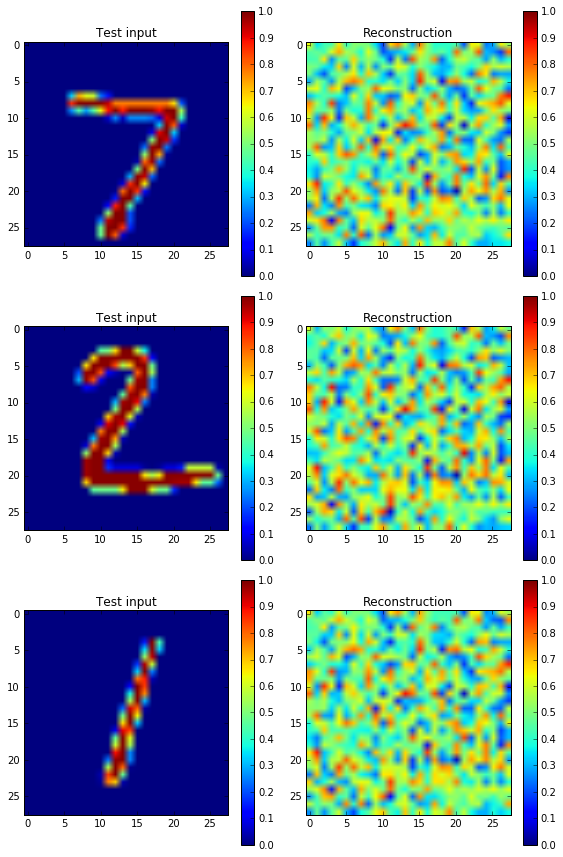

In [13]:
new_sess = tf.Session()
new_sess.run(tf.initialize_all_variables())

# do reconstruction before training
do_reconstruction(new_sess)

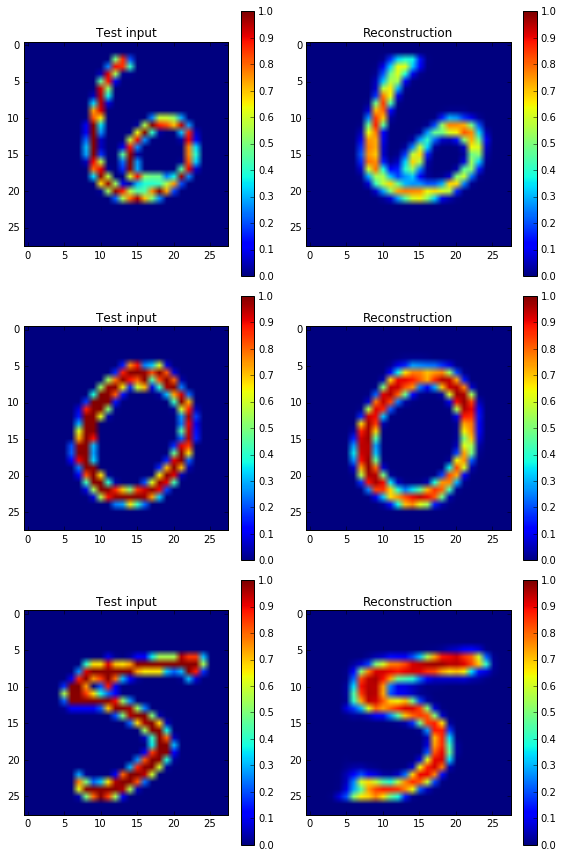

In [14]:
# do reconstruction after training
do_reconstruction(sess)

## Using tensorboard to view summaries

If everything worked correctly, during the training, a directory called `summaries` should have been created. We can use the `tensorboard` tool to visualize our computation graph, and our summaries/events over time.

`tensorboard --logdir=summaries`

and point your browser at the specified address. You should see a web gui. Looking uder the "events" tab you will see the graphs of the mean loss and stdev loss evaluated at the end of each epoch. The full computation graph is under "graph" complete with provided names of tensors (or the default generic names) and scopes will be clustered together, but there is no guarantee it looks good, my graph looks sort of messy. Never the less it can be a good way of visualizing your model. Finally, there is some histogram plotting of the loss avaliable under the "histograms" tab.

## Conclusion

Ok in this notebook, we got started learning about some of the important features of tensorflow, and we implemented an example of a VAE on the MNIST data set. In future notebooks we will continue to explore tensorflow features, and also explore seq2seq and recurrent neural nets. Again, we will eventually build towards a model that is going to be really cool and novel, bioinformatics related, but more on that later.